# Hi :)

----

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# ITG

# Loading the dataset

In [4]:
ITG_features_df= pd.read_csv('Dataset/ITG_features_df.csv')

# Stacking

In [5]:
# Step 1: Extract features and labels
X= ITG_features_df[['F1_sum_vector_magnitude', 'F2_orientation_angle', 'F3_std_magnitude']].values
y= ITG_features_df['Situation'].values

# Step 2: Encode labels ('Fall' → 1, 'Not Fall' → 0)
label_encoder= LabelEncoder()
y_encoded= label_encoder.fit_transform(y)

# Step 3: Split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded, test_size= 0.2, random_state= 48, stratify= y_encoded)

In [6]:
# Step 4: Scaler
scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

SVM

In [7]:
# Step 4: SVM
svm= SVC(kernel='rbf', C= 100, gamma= 1, random_state= 48)
svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=1, random_state=48)

In [8]:
# Step 5: RF
rf= RandomForestClassifier(
    n_estimators= 200,
    max_depth= 10,
    min_samples_split= 2,
    min_samples_leaf= 1,
    random_state= 48
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=48)

In [ ]:
# Step 6: XGB
xgb= XGBClassifier(
    n_estimators= 100,
    max_depth= 5,
    learning_rate= 0.1,
    subsample= 0.8,
    objective= 'binary:logistic',
    use_label_encoder= False,
    eval_metric= 'logloss',
    random_state= 48
)
xgb.fit(X_train, y_train)

f:\Quera\Qvenv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:51:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Step 7: Prediction
X_train_preds= np.column_stack([
    svm.predict(X_train_scaled),
    rf.predict(X_train),
    xgb.predict(X_train),
])

X_test_preds= np.column_stack([
    svm.predict(X_test_scaled),
    rf.predict(X_test),
    xgb.predict(X_test),
])

In [11]:
# Step 8: Train Meta-Model
meta_model= LogisticRegression()
meta_model.fit(X_train_preds, y_train)

final_preds= meta_model.predict(X_test_preds)

Accuracy: 0.6795422031473534
Classification Report:
               precision    recall  f1-score   support

        Fall       0.66      0.73      0.70      2097
    Not Fall       0.70      0.63      0.66      2097

    accuracy                           0.68      4194
   macro avg       0.68      0.68      0.68      4194
weighted avg       0.68      0.68      0.68      4194



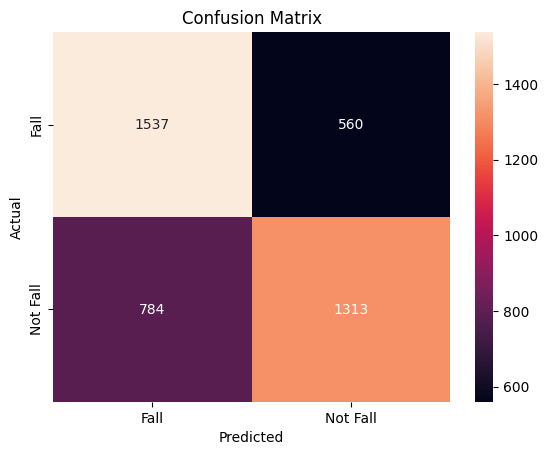

In [13]:
# Step 8: Evaluation
print("Accuracy:", accuracy_score(y_test, final_preds))
print("Classification Report:\n", classification_report(y_test, final_preds, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()